In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
#Set Parameters here
epochs = 100000
batch_size = 1000
train_points = 1000 # 60k total training examples, 10k test examples
test_points = 1000
lr = 0.001
weight_decay = 0.01
initialization_scale = 8.0
#Optmization steps should be train_points/batchsize * epochs 
print(train_points/batch_size * epochs)
print(torch.cuda.is_available())


100000.0
False


In [3]:
#Network Structure
class mnistClassification(nn.Module):
    def __init__(self):
        super(mnistClassification, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = mnistClassification()

with torch.no_grad(): 
    for p in model.parameters(): 
        p.data = initialization_scale * p.data

In [4]:
#Load Data set
train = torchvision.datasets.MNIST(root='mnistdata', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root='mnistdata', train=False, transform=torchvision.transforms.ToTensor(), download=True)
train = torch.utils.data.Subset(train, range(train_points))
test = torch.utils.data.Subset(test, range(test_points))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

1
1


In [5]:
#Training

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot(labels, 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    #Store loss
    train_loss.append(loss)

    #Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    #print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')

Epoch [183/100000], Loss: 2.4469, Train Accuracy: 0.2210, Weight Norm: 152.9786:   0%|          | 183/100000 [00:29<4:23:49,  6.31it/s]


KeyboardInterrupt: 

In [ ]:
#Evaluate
model.eval()
total = 0
correct = 0
one_hots = torch.eye(10, 10)
with torch.no_grad():
        for x, labels in test_loader:
            y = model(x)
            _, predicted = torch.max(y,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 90.76%


Accuracy: 90.76%


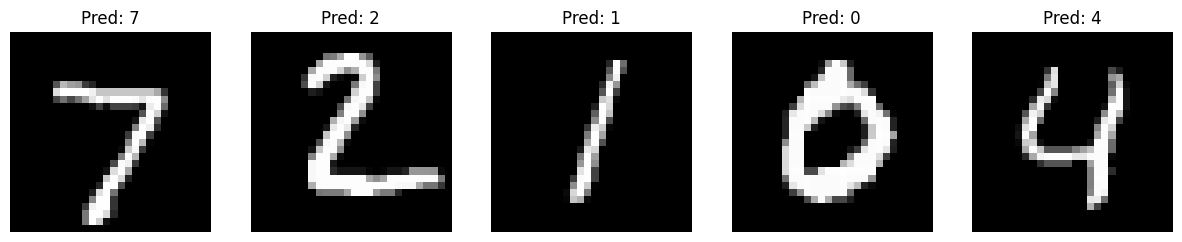

In [ ]:
import matplotlib.pyplot as plt

# Function to display images and predictions
def display_predictions(model, testloader, num_images=5):
    model.eval()
    images, labels = next(iter(testloader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
one_hots = torch.eye(10, 10)

with torch.no_grad():
    for x, labels in test_loader:
        y = model(x)
        _, predicted = torch.max(y, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Accuracy: {100 * accuracy:.2f}%')

# Display example predictions
display_predictions(model, test_loader, num_images=5)


ValueError: x and y must have same first dimension, but have shapes (100000,) and (2694,)

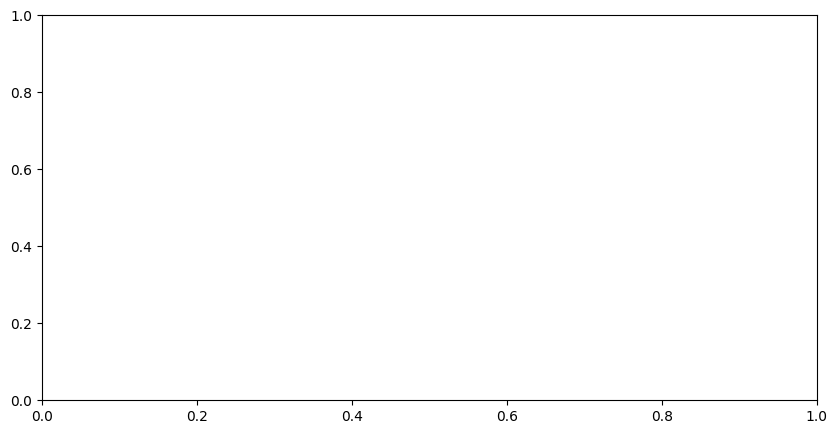

: 

In [ ]:
import matplotlib.pyplot as plt
# Plot weight norms 
plt.figure(figsize=(10, 5)) 
plt.plot(range(epochs), weight_normlist, label='Weight Norm') 
plt.xlabel('Epoch') 
plt.ylabel('Weight Norm') 
plt.title('Weight Norm over Epochs') 
plt.legend() 
plt.show()

In [ ]:
"""#Training

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot(labels, 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    #Store loss
    train_loss.append(loss)
    #Calculate Validation Accuracy
    model.eval()
    total = 0
    correct = 0
    one_hots = torch.eye(10, 10)
    with torch.no_grad():
            for x, labels in test_loader:
                y = model(x)
                _, predicted = torch.max(y,1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    #Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    #print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')"""

"#Training\n\ncriterion = nn.MSELoss()\noptimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)\n\ntrain_acc = []\nval_acc = []\ntrain_loss = []\nweight_normlist = []\n\n#Loop\nbar = tqdm(range(epochs))\nfor epoch in bar:\n    model.train()\n    running_loss = 0.0\n    correct_train = 0\n    total_train = 0\n    \n    for images, labels in train_loader:\n        optimizer.zero_grad()\n        outputs = model(images)\n        labels_one_hot = F.one_hot(labels, 10).float()\n        loss = criterion(outputs, labels_one_hot)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n    #Calculate Train Accuracy\n    _, predicted = torch.max(outputs.data, 1)\n    correct_train += (predicted == labels).sum().item()\n    total_train += labels.size(0)\n    train_accuracy = correct_train / total_train\n    train_acc.append(train_accuracy)\n    #Store loss\n    train_loss.append(loss)\n    #Calculate Validation Accuracy\n    model.eval()\n    tot